# Solve steady state

In [1]:
from Bequests_ss import nonuniform_grid, OLGModel, solve_HH_SS, SS_distribution, solve_SS
import numpy as np
import matplotlib.pyplot as plt
import time


Text(0.5, 1.0, 'Age-efficiency profile')

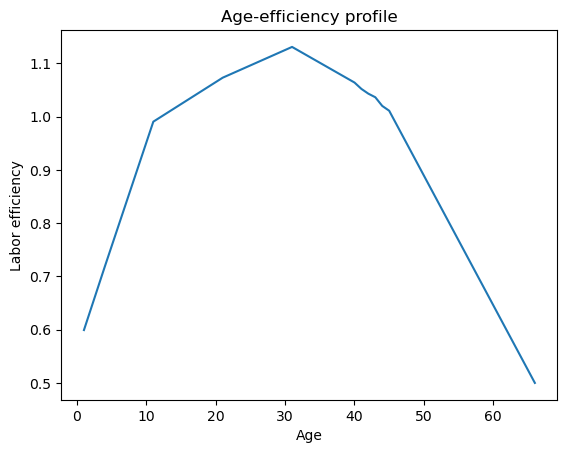

In [2]:
# read in ef.txt as a numpy array
ef = np.loadtxt('ef.txt', delimiter=',')
eta_end = np.linspace(ef[-1], .5, 67-len(ef))
eta = np.concatenate([ef, eta_end[1:]])

# plot ef across [1, .., len(ef)]
x = np.arange(1, len(eta)+1)
plt.plot(x, eta)
plt.xlabel('Age')
plt.ylabel('Labor efficiency')
plt.title('Age-efficiency profile')

Text(0, 0.5, 'Mortality probability')

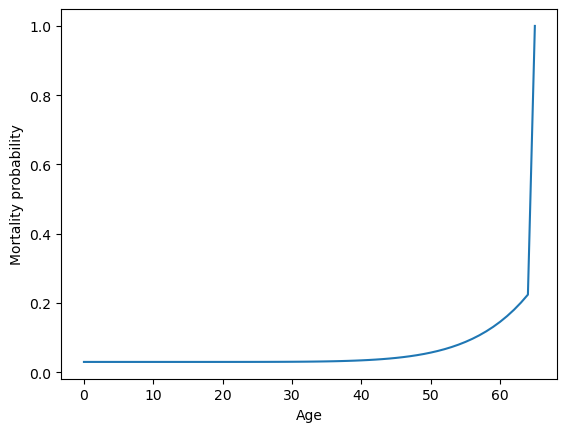

In [3]:
rho = nonuniform_grid(.03, .25, n=66, density=8)
rho[-1] = 1.0
# plot rho against its index
plt.figure()
plt.plot(rho)
plt.xlabel('Age')
plt.ylabel('Mortality probability')

Text(0, 0.5, 'Bequests share')

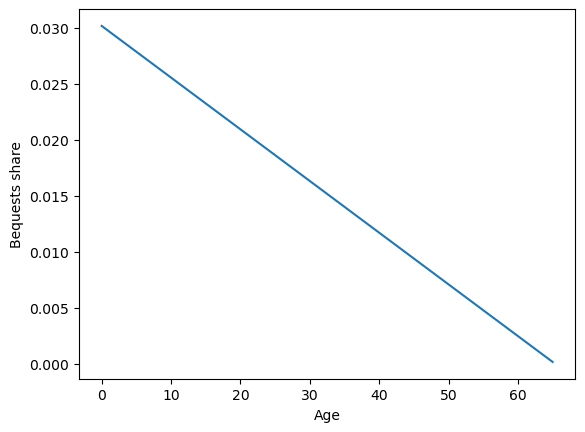

In [4]:
zeta = np.linspace(1, .005, 66)
zeta /= zeta.sum()
# plot zeta against its index
plt.figure()
plt.plot(zeta)
plt.xlabel('Age')
plt.ylabel('Bequests share')

In [5]:
b_grid = nonuniform_grid(0, 30, n=200, density=2)

# initialize the OLG model
og = OLGModel(b_grid=b_grid, eta=eta, rho=rho, zeta=zeta)

Text(0, 0.5, 'Population share')

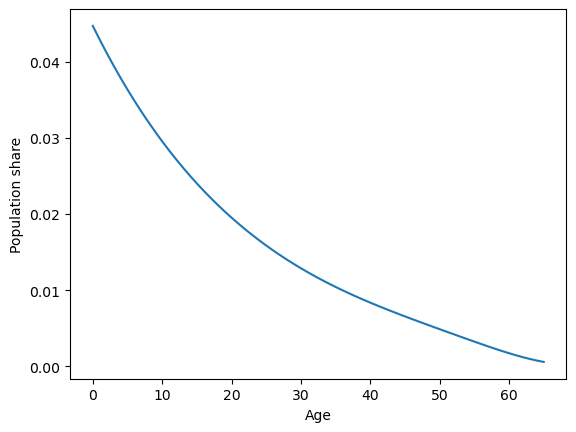

In [6]:
# plot omega against its index
plt.figure()
plt.plot(og.omega)
plt.xlabel('Age')
plt.ylabel('Population share')

In [7]:
og.omega[-1]

0.0005984596307873453

In [9]:
begin = time.time()
b_policy, c_policy, n_policy = solve_HH_SS(og, r=.064, w=1.165, BQ=.102)
end = time.time()
print('Time elapsed: ', end-begin)

Time elapsed:  0.0032660961151123047


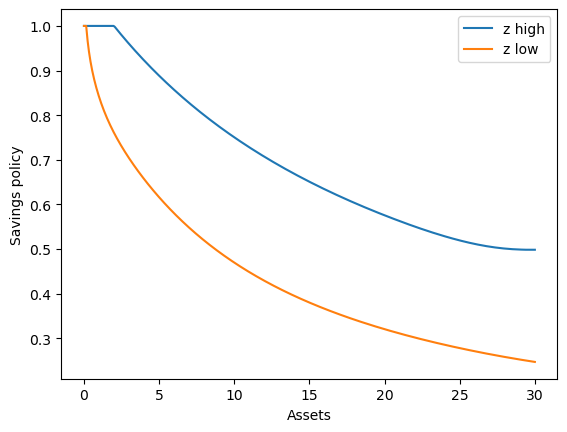

In [40]:
# plot b_policy against b_grid
plt.figure()
plt.plot(b_grid, n_policy[10], label=('z high', 'z low'))
plt.xlabel('Assets')
plt.ylabel('Savings policy')
plt.legend()


In [12]:
begin = time.time()
h = SS_distribution(og, b_policy)
end = time.time()
print('SS_distribution takes', end-begin, 'seconds')

SS_distribution takes 0.0016090869903564453 seconds


Text(0.5, 1.0, 'Steady state distribution of assets')

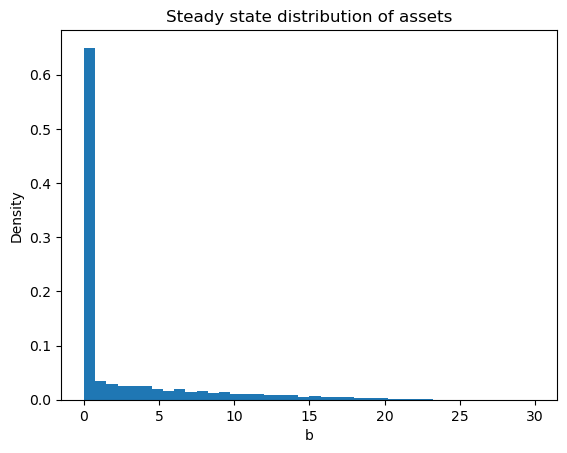

In [13]:
# plot histogram of h summing across axis 0 and 2
h_collapsed = h.sum(axis=2).sum(axis=0)
plt.hist(b_grid, bins=40, weights=h_collapsed)
plt.xlabel('b')
plt.ylabel('Density')
plt.title('Steady state distribution of assets')

Text(0.5, 1.0, 'Steady state distribution of assets')

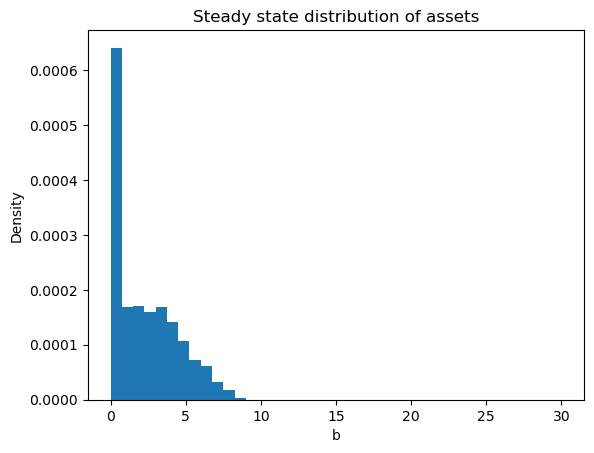

In [31]:
# plot histogram of h summing across axis 0 and 2
j = 60
h_collapsed = h.sum(axis=2)[j]
plt.hist(b_grid, bins=40, weights=h_collapsed)
plt.xlabel('b')
plt.ylabel('Density')
plt.title('Steady state distribution of assets')

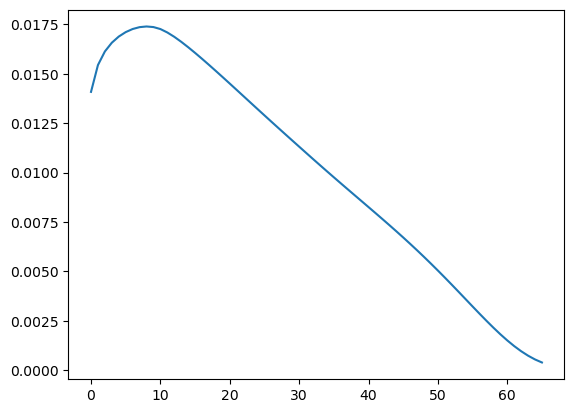

In [33]:
consumption_profile = np.zeros(66)

for s in range(66):
    consumption_profile[s] = np.sum(h[s] * c_policy[s])

plt.plot(consumption_profile)

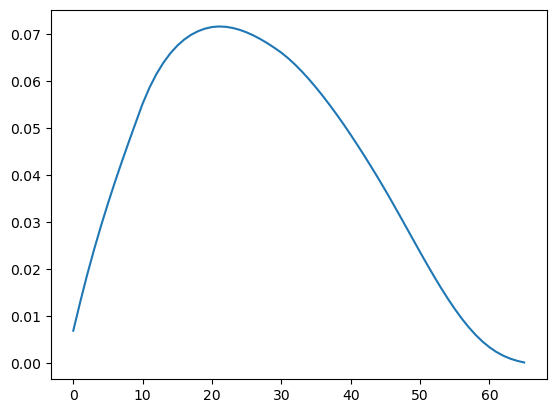

In [34]:
assets_profile = np.zeros(66)

for s in range(66):
    assets_profile[s] = np.sum(h[s] * b_policy[s])

plt.plot(assets_profile)

In [15]:
begin = time.time()
eqbm = solve_SS(og, tol=0.00001, max_iter=500, xi=.5, initial_guess=(2.0, .25, 0.5))
end = time.time()
print('Time elapsed: ', end - begin)

Converged to steady state in  21  iterations
Time elapsed:  0.11778688430786133


In [16]:
print('K, L, BQ, r, w: ', np.round(eqbm, 5))

K, L, BQ, r, w:  [2.64374 0.50029 0.10199 0.06405 1.16536]


# Solve transition path

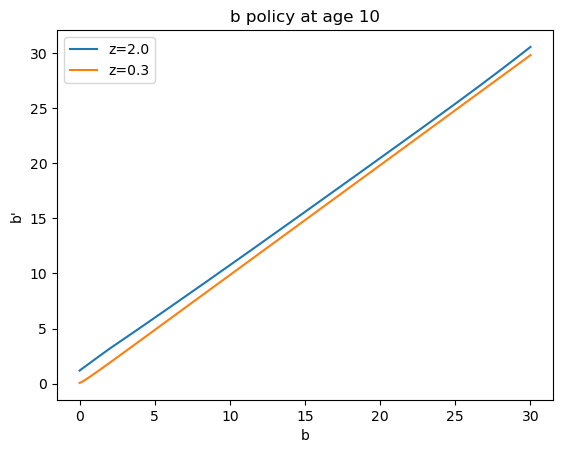

In [19]:
from Bequests_TPI import solve_HH_transition, solve_transition_path

BQ_vec = np.repeat(eqbm[2], og.S)
r_vec = np.repeat(eqbm[3], og.S)
w_vec = np.repeat(eqbm[4], og.S)

b_transition, c_transition, n_transition = solve_HH_transition(og, r_vec, w_vec, BQ_vec)

# plot a policy at age j
j = 10
plt.plot(b_grid, b_transition[j-1, :, 0], label=f'z={og.z_grid[0]}')
plt.plot(b_grid, b_transition[j-1, :, 1], label=f'z={og.z_grid[1]}')
plt.xlabel('b')
plt.ylabel('b\'')
plt.title(f'b policy at age {j}')
plt.legend()


In [20]:
# test if b_transition is the same as b_policy
b_policy, c_policy, n_policy = solve_HH_SS(og, r=eqbm[3], w=eqbm[4], BQ=eqbm[2])
np.allclose(b_policy, b_transition)

True

In [23]:
og2 = OLGModel(b_grid=b_grid, eta=eta, rho=rho, zeta=zeta, theta=.25)
K_0, L_0, BQ_0, r_0, w_0 = solve_SS(og2, tol=1e-5, max_iter=1000, xi=.5)
b_2, c_2, n_2 = solve_HH_SS(og2, r=r_0, w=w_0)
h_0 = SS_distribution(og2, b_2)

T = og.S * 3
begin = time.time()
transition_path = solve_transition_path(og, T, (K_0, L_0, BQ_0, h_0), tol=1e-4, maxiter=500, xi=0.5)
end = time.time()
print(f'Time elapsed: {end-begin} seconds')

Converged to steady state in  19  iterations
Converged to steady state in  7  iterations
Transition path converged in 14 iterations
Time elapsed: 13.80866289138794 seconds


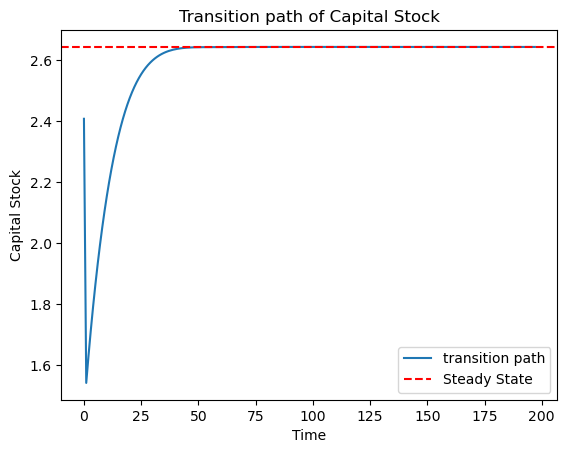

In [24]:
K_path, L_path, BQ_path, r_path, w_path = transition_path
plt.plot(K_path, label='transition path')
# add horizontal line at K_ss
plt.axhline(y=eqbm[0], color='r', linestyle='--', label='Steady State')
plt.xlabel('Time')
plt.ylabel('Capital Stock')
plt.title('Transition path of Capital Stock')
plt.legend()

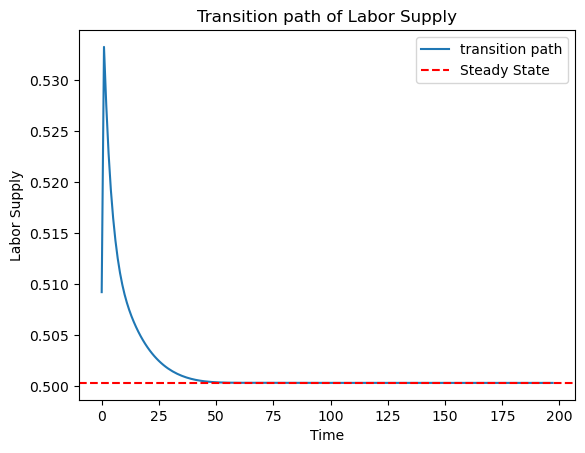

In [25]:
plt.plot(L_path, label='transition path')
# add horizontal line at L_ss
plt.axhline(y=eqbm[1], color='r', linestyle='--', label='Steady State')
plt.xlabel('Time')
plt.ylabel('Labor Supply')
plt.title('Transition path of Labor Supply')
plt.legend()

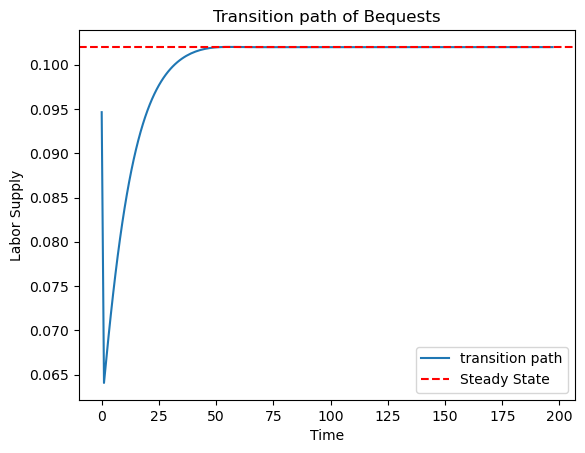

In [26]:
plt.plot(BQ_path, label='transition path')
# add horizontal line at L_ss
plt.axhline(y=eqbm[2], color='r', linestyle='--', label='Steady State')
plt.xlabel('Time')
plt.ylabel('Labor Supply')
plt.title('Transition path of Bequests')
plt.legend()

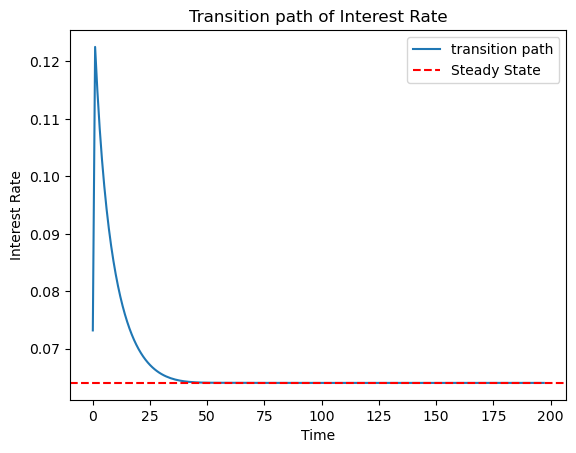

In [27]:
plt.plot(r_path, label='transition path')
# add horizontal line at r_ss
plt.axhline(y=eqbm[3], color='r', linestyle='--', label='Steady State')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.title('Transition path of Interest Rate')
plt.legend()

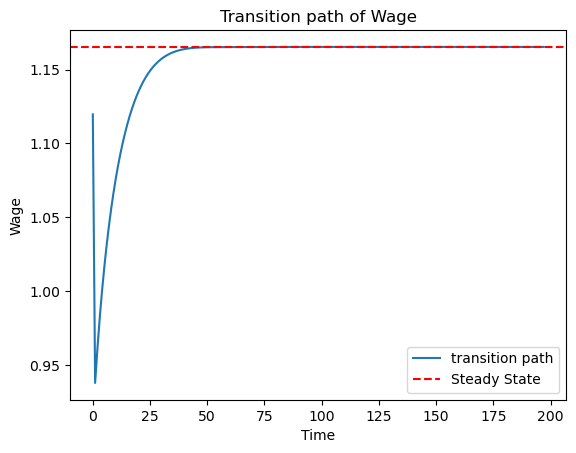

In [28]:
plt.plot(w_path, label='transition path')
# add horizontal line at w_ss
plt.axhline(y=eqbm[4], color='r', linestyle='--', label='Steady State')
plt.xlabel('Time')
plt.ylabel('Wage')
plt.title('Transition path of Wage')
plt.legend()